<font size='5'> Sentiment Analysis Using Neural Networks </font>

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from unidecode import unidecode
from collections import defaultdict
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords 
from collections import Counter
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from nltk.stem import WordNetLemmatizer
import contextlib
import os
with contextlib.redirect_stdout(open(os.devnull, 'w')), contextlib.redirect_stderr(open(os.devnull, 'w')):
    nltk.download('wordnet', quiet=True)
    nltk.download('punkt', quiet=True)
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchinfo import summary
import random
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

Import the Data

In [4]:
#amazon reviews
with open ('Data/amazon_cells_labelled.txt', 'r') as file:
    amazon_reviews=file.readlines()
print(amazon_reviews[:2])


['So there is no way for me to plug it in here in the US unless I go by a converter.\t0\n', 'Good case, Excellent value.\t1\n']


In [5]:
#yelp reviews
with open ('Data/yelp_labelled.txt', 'r') as file:
    yelp_reviews=file.readlines()
print(yelp_reviews[:2])

['Wow... Loved this place.\t1\n', 'Crust is not good.\t0\n']


In [6]:
#imdb reviews
with open ('Data/imdb_labelled.txt' , 'r') as file:
    imdb_reviews=file.readlines()
print(imdb_reviews[:2])

['A very, very, very slow-moving, aimless movie about a distressed, drifting young man.  \t0\n', 'Not sure who was more lost - the flat characters or the audience, nearly half of whom walked out.  \t0\n']


In [7]:
print(f"Number of Amazon Reviews: {len(amazon_reviews)}")
print(f"Number of Yelp Reviews: {len(yelp_reviews)}")
print(f"Number of IMDB Reviews: {len(imdb_reviews)}")

Number of Amazon Reviews: 1000
Number of Yelp Reviews: 1000
Number of IMDB Reviews: 1000


Split the review and the sentiment label. 

In [8]:
#Amazon
amazon_reviews_list = []
amazon_sentiments_list = []

for line in yelp_reviews:
    review, sentiment = line.strip().split('\t')
    amazon_reviews_list.append(review)
    amazon_sentiments_list.append(int(sentiment)) 

In [9]:
#Yelp
yelp_reviews_list = []
yelp_sentiments_list = []

for line in yelp_reviews:
    review, sentiment = line.strip().split('\t')
    yelp_reviews_list.append(review)
    yelp_sentiments_list.append(int(sentiment)) 

In [10]:
#IMDB
imdb_reviews_list = []
imdb_sentiments_list = []

for line in imdb_reviews:
    review, sentiment = line.strip().split('\t')
    imdb_reviews_list.append(review)
    imdb_sentiments_list.append(int(sentiment)) 

Examine the sentiment counts in each set

In [11]:
print("Amazon Sentiment Counts:")
print(pd.Series(amazon_sentiments_list).value_counts().to_string(), end="\n\n")
print("Yelp Sentiment Counts:")
print(pd.Series(yelp_sentiments_list).value_counts().to_string(), end="\n\n")
print('IMDB Sentiment Counts:')
print(pd.Series(imdb_sentiments_list).value_counts().to_string(), end="\n\n")


Amazon Sentiment Counts:
1    500
0    500

Yelp Sentiment Counts:
1    500
0    500

IMDB Sentiment Counts:
0    500
1    500



The rest of the analysis will utilize the yelp reviews

In [12]:
yelp_df = pd.DataFrame({
    'review': yelp_reviews_list,
    'sentiment': yelp_sentiments_list
})

reviews=yelp_df
print(reviews.shape)

(1000, 2)


<font size='4'> Exploratory Data Analysis </font>

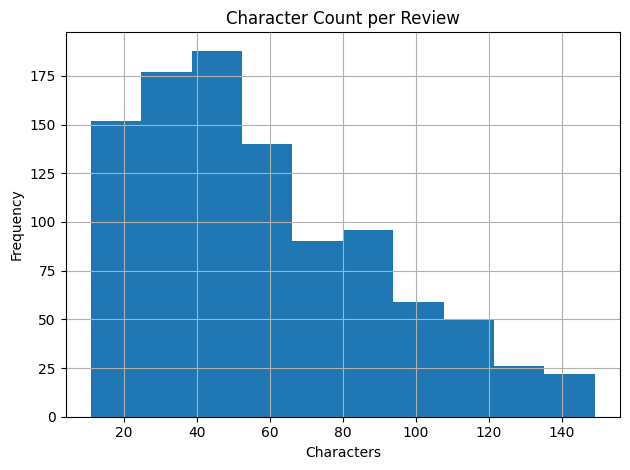

In [13]:
reviews['review'].str.len().hist()
plt.title('Character Count per Review')
plt.xlabel('Characters')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

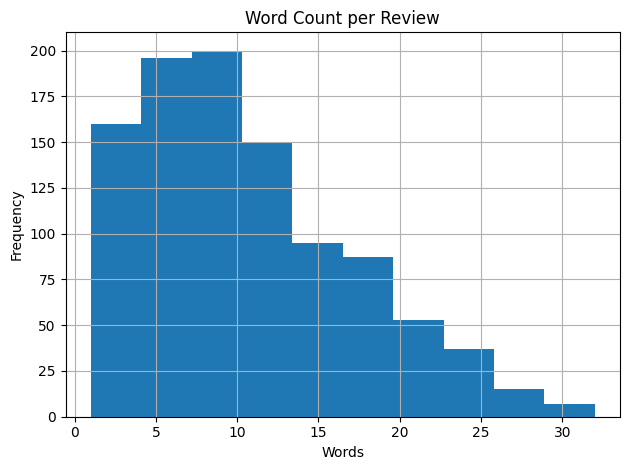

In [14]:
reviews['review'].str.split().str.len().hist()
plt.title('Word Count per Review')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [15]:
#Count HTML Tags
def count_html_tags(text):
    return len(re.findall(r'<.*?>', text))

html_count = [count_html_tags(review) for review in reviews['review']]
print(sum(html_count))

0


In [16]:
#Count reviews with special charecters
def count_special_characters(text):
    return len(re.findall(r'[^a-zA-Z0-9\s!\"#$%&\'()*+,-./:;?\[\]]', text))

special_char_count = [count_special_characters(review) for review in reviews['review']]
total_special_characters = sum(special_char_count)
print(total_special_characters)

4


In [17]:
#Reviews w special charecters - get an idea of the problems
reviews_with_special_chars = [review for review in reviews['review'] if count_special_characters(review) > 0]
for i, review in enumerate(reviews_with_special_chars[:15]):
    print(f"Review {i+1}: {review}")

Review 1: My fiancé and I came in the middle of the day and we were greeted and seated right away.
Review 2: I really enjoyed Crema Café before they expanded; I even told friends they had the BEST breakfast.
Review 3: The crêpe was delicate and thin and moist.
Review 4: The only thing I wasn't too crazy about was their guacamole as I don't like it puréed.


<font size='4'> Data Preparation </font>

Neural Networks require clean, formatted data for effective model building.

In [20]:
#Apply Unidecode to get rid of accents and special characters
reviews['review'] = reviews['review'].apply(unidecode)

In [21]:
#Confirm no more special charecters
def count_special_characters(text):
    return len(re.findall(r'[^a-zA-Z0-9\s!\"#$%&\'()*+,-./:;?\[\]]', text))

special_char_count = [count_special_characters(review) for review in reviews['review']]
total_special_characters = sum(special_char_count)
print(total_special_characters)

0


Capitilization

In [22]:
#New column for all caps reviews
all_caps_reviews = reviews['review'].apply(lambda x: isinstance(x, str) and x.isupper())
for i, review in enumerate(reviews.loc[all_caps_reviews, 'review'].head()):
    print(f"Capitlized Review {i+1}: {review}")

Capitlized Review 1: DELICIOUS!!
Capitlized Review 2: RUDE & INCONSIDERATE MANAGEMENT.
Capitlized Review 3: WILL NEVER EVER GO BACK AND HAVE TOLD MANY PEOPLE WHAT HAD HAPPENED.
Capitlized Review 4: TOTAL WASTE OF TIME.
Capitlized Review 5: AVOID THIS ESTABLISHMENT!


In [23]:
#reviews with at least one capitilized word
reviews_with_capitalized_words = reviews['review'].apply(
    lambda x: isinstance(x, str) and bool(re.search(r'\b[A-Z]{2,}\b', x)))
for i, review in enumerate(reviews.loc[reviews_with_capitalized_words, 'review'].head()):
    print(f"Review with Capitalized Word {i+1}: {review}")

Review with Capitalized Word 1: Honeslty it didn't taste THAT fresh.)
Review with Capitalized Word 2: This place receives stars for their APPETIZERS!!!
Review with Capitalized Word 3: Never been to Hard Rock Casino before, WILL NEVER EVER STEP FORWARD IN IT AGAIN!
Review with Capitalized Word 4: I LOVED their mussels cooked in this wine reduction, the duck was tender, and their potato dishes were delicious.
Review with Capitalized Word 5: The food was delicious, our bartender was attentive and personable AND we got a great deal!


In [24]:
reviews['all_caps_count'] = reviews['review'].apply(lambda x: len(re.findall(r'\b[A-Z]{2,}\b', x)) if isinstance(x, str) else 0)
reviews['is_all_caps'] = reviews['review'].apply(lambda x: isinstance(x, str) and x.isupper())
print(f'Reviews with fully capitalized words: {reviews["all_caps_count"].sum()}')
print(f'Fully Capitalized Reviews: {reviews["is_all_caps"].sum()}')

Reviews with fully capitalized words: 96
Fully Capitalized Reviews: 5


In [26]:
#Make everything lowercase
reviews['review'] = reviews['review'].apply(lambda x: x.lower())
reviews.head(1)

,review,sentiment,all_caps_count,is_all_caps
0,wow... loved this place.,1,0,False


General Text Cleaning Function
- Remove punctuation that doesn't contain sentiment
- remove whitespace

In [27]:
def clean_text(review):  
    review = re.sub(r'[^\w\s?!.,]', '', review)
    review = re.sub(r'\s([?!.,])', r'\1', review)
    review = re.sub(r'\s+', ' ', review).strip() 
    return review

reviews['review'] = reviews['review'].apply(clean_text)

In [28]:
print(reviews['review'].head(5))

0                             wow... loved this place.
1                                   crust is not good.
2            not tasty and the texture was just nasty.
3    stopped by during the late may bank holiday of...
4    the selection on the menu was great and so wer...
Name: review, dtype: object


<font size='3' > Vocabulary Size </font>

Creating the corpus to evaluate word counts.
- vocabulary size
- stop words

In [29]:
#nltk.download('stopwords')
stop=set(stopwords.words('english'))

In [30]:
#Corpus
size=reviews['review'].str.split()
size=size.values.tolist()
corpus = [word for i in size for word in i]

In [31]:
print(corpus)

['wow...', 'loved', 'this', 'place.', 'crust', 'is', 'not', 'good.', 'not', 'tasty', 'and', 'the', 'texture', 'was', 'just', 'nasty.', 'stopped', 'by', 'during', 'the', 'late', 'may', 'bank', 'holiday', 'off', 'rick', 'steve', 'recommendation', 'and', 'loved', 'it.', 'the', 'selection', 'on', 'the', 'menu', 'was', 'great', 'and', 'so', 'were', 'the', 'prices.', 'now', 'i', 'am', 'getting', 'angry', 'and', 'i', 'want', 'my', 'damn', 'pho.', 'honeslty', 'it', 'didnt', 'taste', 'that', 'fresh.', 'the', 'potatoes', 'were', 'like', 'rubber', 'and', 'you', 'could', 'tell', 'they', 'had', 'been', 'made', 'up', 'ahead', 'of', 'time', 'being', 'kept', 'under', 'a', 'warmer.', 'the', 'fries', 'were', 'great', 'too.', 'a', 'great', 'touch.', 'service', 'was', 'very', 'prompt.', 'would', 'not', 'go', 'back.', 'the', 'cashier', 'had', 'no', 'care', 'what', 'so', 'ever', 'on', 'what', 'i', 'had', 'to', 'say', 'it', 'still', 'ended', 'up', 'being', 'wayyy', 'overpriced.', 'i', 'tried', 'the', 'cape',

In [32]:
#Vocabulary size - Only unique instances
vocab=set(corpus)
vocab_size=len(vocab)
print(f'Vocab Size (Unique Word Count): {vocab_size}')

#Vocabulary size - repeats included in the count
vocab_repeats_counter=Counter(word for word in corpus if word not in stop)
print(f'Total Vocab Size(Repeats Included): {sum(vocab_repeats_counter.values())}')

Vocab Size (Unique Word Count): 2656
Total Vocab Size(Repeats Included): 5858


In [33]:
#Count Stopwords - repeats included in the count
stopword_counter = Counter(word for word in corpus if word in stop)
print(sum(stopword_counter.values()))

4988


Visualize
- Vocabulary
- Stopwords

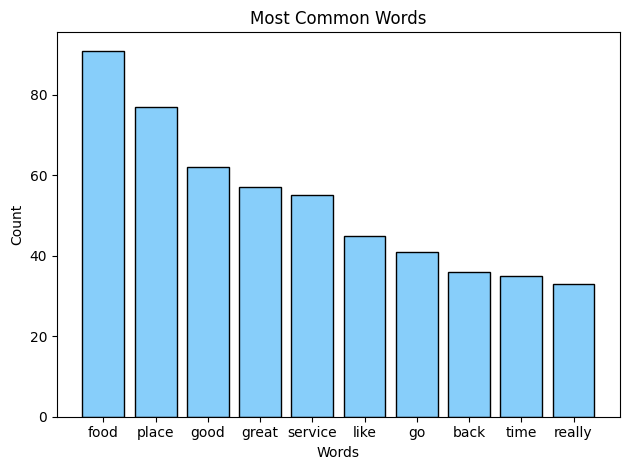

In [34]:
#Plot top 10 words in the vocab
top_n = 10
common_vocab_words=vocab_repeats_counter.most_common(top_n)
words, counts = zip(*common_vocab_words)

#Plot
plt.bar(words, counts, color='lightskyblue', edgecolor='black')
plt.title('Most Common Words')
plt.xlabel('Words')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

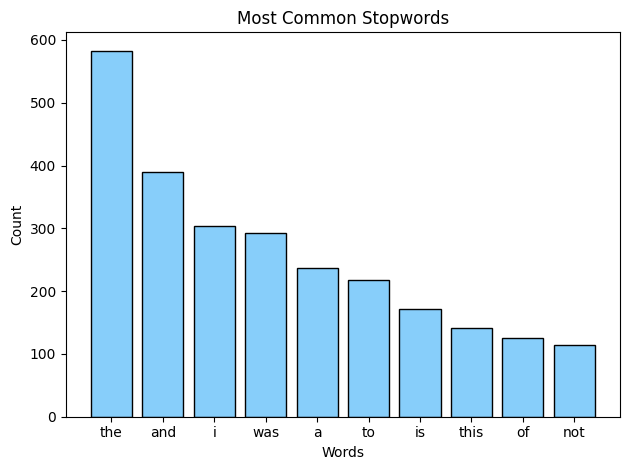

In [35]:
#Plot top 10 stopwords
top_n = 10
common_stopwords=stopword_counter.most_common(top_n)
words, counts = zip(*common_stopwords)

#Plot
plt.bar(words, counts, color='lightskyblue', edgecolor='black')
plt.title('Most Common Stopwords')
plt.xlabel('Words')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

<font size='3'> Preprocess Corpus for Word2Vec Model </font>

In [36]:
#Tokenize the corpus before embedding.
corpus = []
for review in reviews['review']:
    tokens = nltk.word_tokenize(review)
    filtered_tokens = [word for word in tokens if word not in stop]
    corpus.append(filtered_tokens)

print(corpus[:2])

[['wow', '...', 'loved', 'place', '.'], ['crust', 'good', '.']]


Lemmatization: Reduce words to their base form.

In [37]:
lemmatizer = WordNetLemmatizer()

lemmatized_corpus = []
for review in corpus:
    lemmatized_review = [lemmatizer.lemmatize(word) for word in review]
    lemmatized_corpus.append(lemmatized_review)

In [38]:
#Create Embeddings
model = Word2Vec(sentences=lemmatized_corpus, vector_size=300, window=5, min_count=1)

In [41]:
print(model.wv[1])

[-0.00843505  0.0426214   0.00857592  0.02830428  0.00412714 -0.0347152
  0.02202368  0.07501023  0.01717939 -0.02069491  0.0190316  -0.03183806
  0.02438055 -0.00496704 -0.02815322 -0.02352361  0.01874393 -0.01048474
  0.00267083 -0.0081353  -0.01686834  0.00208905  0.02542482  0.01926062
  0.01850714  0.00283945 -0.029018    0.00334974 -0.01674107 -0.0220916
  0.00512318 -0.02183513  0.00319731 -0.01899268 -0.00983746  0.01331006
  0.02239798 -0.04169453 -0.01613886  0.00429481 -0.01080369  0.00923661
 -0.01149612 -0.03119473  0.02607927  0.03795136  0.01105547  0.01201834
 -0.01071758  0.0270404   0.01272298  0.0024176  -0.02422676  0.00065847
 -0.00803188  0.02183824  0.02533819  0.00054963  0.00920179  0.01048793
 -0.01566747 -0.00411589  0.00481478  0.00618749  0.00693381  0.00725641
 -0.00320814  0.01593132 -0.02351987 -0.01105362  0.00299915  0.01728268
  0.0253859  -0.0163094  -0.00631266  0.01758804 -0.03625762  0.00773921
 -0.02896747  0.02601652 -0.03627138 -0.02968865  0.0

Map tokenized, lemmatized words to numeric index's

In [42]:
word_to_index = {word: idx for idx, word in enumerate(model.wv.index_to_key)}

numeric_corpus = []
for review in lemmatized_corpus:
    numeric_review = [word_to_index[word] for word in review if word in word_to_index]
    numeric_corpus.append(numeric_review)

<font size='3'> Evlauate Sequence Length </font>

In [43]:
sequence_length=[len(tokens) for tokens in lemmatized_corpus]

In [44]:
#Some statistics
print(f"Maximum Sequence Length: {max(sequence_length)}")
print(f"Average Sequence Length: {sum(sequence_length) / len(sequence_length)}")
print(f"Minimum Sequence Length: {min(sequence_length)}")

Maximum Sequence Length: 22
Average Sequence Length: 7.183
Minimum Sequence Length: 1


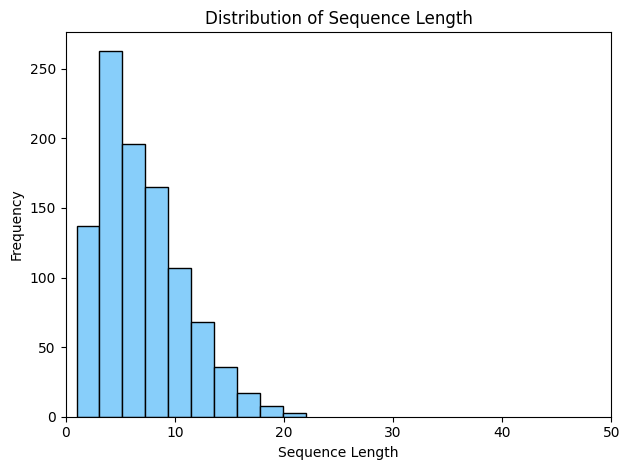

In [45]:
#Visualize
plt.hist(sequence_length, bins=10, color='lightskyblue', edgecolor='black')
plt.title('Distribution of Sequence Length')
plt.xlabel('Sequence Length')
plt.xlim(0,50)
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

Determine maximum sequence length
- 95th percentile

In [46]:
max_length = np.percentile(sequence_length, 95)
max_length = int(max_length)
print(max_length)

14


<font size='4'> Padding </font>

Pad and truncate the numeric indexes. 


In [47]:
standardized_corpus = pad_sequences(numeric_corpus, maxlen=max_length, padding='post', truncating='post')

In [48]:
print("After Padding:")
print(standardized_corpus[0])

After Padding:
[447  14 101   4   0   0   0   0   0   0   0   0   0   0]


In [49]:
# Map padded indices to embeddings
embedded_corpus = []
for review in standardized_corpus:
    review_embeddings = [model.wv[word] if word in model.wv else np.zeros(model.vector_size) for word in review]
    embedded_corpus.append(review_embeddings)
   

Train/val/test

In [50]:
X=embedded_corpus
y=reviews['sentiment']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.2, random_state=13)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=13)

In [51]:
print(f"Train size: {len(X_train)}")
print(f"Validation size: {len(X_val)}")
print(f"Test size: {len(X_test)}")

Train size: 800
Validation size: 100
Test size: 100


In [52]:
print(type(X_train))

<class 'list'>


<font size='4'> Prepared Dataset </font>

In [53]:
X_train_df = pd.DataFrame(X_train)
y_train_df = pd.DataFrame(y_train)
X_val_df = pd.DataFrame(X_val)
y_val_df = pd.DataFrame(y_val)
X_test_df = pd.DataFrame(X_test)
y_test_df = pd.DataFrame(y_test)

In [55]:
#X_train_df.to_csv('X_train.csv', index=False)
#y_train_df.to_csv('y_train.csv', index=False)
#X_val_df.to_csv('X_val.csv', index=False)
#y_val_df.to_csv('y_val.csv', index=False)
#X_test_df.to_csv('X_test.csv', index=False)
#y_test_df.to_csv('y_test.csv', index=False)

<font size='5'> Create Neural Network </font>

Prepare data for PyTorch
- Create dataset class
- Create  data loaders

In [56]:
#Original
class ReviewDataset(Dataset):
    def __init__(self, embedded_data, labels):
        self.embedded_data = embedded_data
        self.labels = labels
        
    def __len__(self):
        return len(self.embedded_data)
        
    def __getitem__(self, idx):
        data = torch.tensor(self.embedded_data[idx], dtype=torch.float32)
        # Ensure label is a 1D tensor [batch_size]
        label = torch.tensor(self.labels[idx], dtype=torch.float32).squeeze()
        return data, label

In [57]:
#Create data set
train_dataset = ReviewDataset(X_train, y_train.tolist())
val_dataset = ReviewDataset(X_val, y_val.tolist())
test_dataset = ReviewDataset(X_test, y_test.tolist())

#create data loader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

Long Short Term Mermory Model

In [58]:
class LSTMModel(nn.Module):
    def __init__(self, hidden_dim, output_dim=1, n_layers=2, dropout=0.3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(300, hidden_dim, num_layers=n_layers, bidirectional=True, batch_first=True, dropout=dropout) 
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        lstm_out, (hidden, cell) = self.lstm(x)  
        last_hidden_state = hidden[-1]  
        out = self.fc(last_hidden_state)  
        return out

Set Hyperparameters and initialize the model

In [59]:
embedding_dim = 300
hidden_dim = 128
vocab_size = len(word_to_index)
output_dim = 1 
dropout = 0.3
num_layers=2

model = LSTMModel(hidden_dim=hidden_dim, output_dim=1, n_layers=2, dropout=0.3)

In [60]:
def init_he_weights(m):
    if isinstance(m, nn.LSTM):
        for name, param in m.named_parameters():
            if 'weight' in name:
                nn.init.kaiming_normal_(param, mode='fan_in', nonlinearity='relu')
            elif 'bias' in name:
                nn.init.zeros_(param)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
        nn.init.zeros_(m.bias)

model.apply(init_he_weights)

LSTMModel(
  (lstm): LSTM(300, 128, num_layers=2, batch_first=True, dropout=0.3, bidirectional=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

Define Optimizer, loss, learning rate

In [61]:
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=.0005, weight_decay=.001)
scheduler=StepLR(optimizer, step_size=3, gamma=0.4)

Train/Val Loop

In [ ]:
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

seed = 1
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.cuda.manual_seed_all(seed) 
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

# Tensorboard setup
run_name = 87
writer = SummaryWriter(log_dir=f'runs/{run_name}')

train_losses = []
val_losses = []

num_epochs = 70
model.train()

# Early stopping setup
patience = 10
best_val_loss = float('inf')
epochs_without_improvement = 0

total_batches = len(train_loader) * num_epochs
with tqdm(total=total_batches, desc='Training', ncols=100, dynamic_ncols=True) as pbar:
    
    # Training loop
    for epoch in range(num_epochs):
        train_loss = 0.0
        train_correct = 0
        model.train()  
        for batch_idx, (data, target) in enumerate(train_loader):
            if target.dtype == torch.bool:
                target = target.long()

            target = target.unsqueeze(1)            
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, target)  
            loss.backward() 

        
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=100.0)

            optimizer.step()

            train_loss += loss.item() * data.size(0)
            preds = torch.sigmoid(output).round().squeeze(1)
            train_correct += (preds == target.squeeze(1)).sum().item()

            pbar.update(1)

        train_loss = train_loss / len(train_loader.dataset) 
        train_accuracy = 100. * train_correct / len(train_loader.dataset) 

        writer.add_scalar('Loss/train', train_loss, epoch)
        writer.add_scalar('Accuracy/train', train_accuracy, epoch)
        lr = optimizer.param_groups[0]['lr']
        writer.add_scalar('Learning Rate', lr, epoch)

        print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {train_loss:.4f}, Training Accuracy: {train_accuracy:.2f}%")

        # Validation loop
        val_loss = 0.0
        val_correct = 0
        model.eval()  
        with torch.no_grad():
            for data, target in val_loader:
                if target.dtype == torch.bool:
                    target = target.long()

                target = target.unsqueeze(1)
                output = model(data)
                loss = criterion(output, target)  
                val_loss += loss.item() * data.size(0)
                preds = torch.sigmoid(output).round().squeeze(1) 
                val_correct += (preds == target.squeeze(1)).sum().item() 

        val_loss = val_loss / len(val_loader.dataset)
        val_accuracy = 100. * val_correct / len(val_loader.dataset)

        writer.add_scalar('Loss/val', val_loss, epoch)
        writer.add_scalar('Accuracy/val', val_accuracy, epoch)

        print(f"Epoch [{epoch+1}/{num_epochs}], Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            epochs_without_improvement = 0 
        else:
            epochs_without_improvement += 1
            if epochs_without_improvement >= patience:
                print(f"Early stopping after {epoch+1} epochs")
                break

        scheduler.step()

writer.close()

<font size='4'> Model Summary </font>

In [84]:
summary(model, input_size=(12, 100, 300))

Layer (type:depth-idx)                   Output Shape              Param #
LSTMModel                                [12, 1]                   --
├─LSTM: 1-1                              [12, 100, 256]            835,584
├─Linear: 1-2                            [12, 1]                   129
Total params: 835,713
Trainable params: 835,713
Non-trainable params: 0
Total mult-adds (Units.GIGABYTES): 1.00
Input size (MB): 1.44
Forward/backward pass size (MB): 2.46
Params size (MB): 3.34
Estimated Total Size (MB): 7.24

Save the model

In [56]:
#save_path = "best_yelp_model.pth"
#torch.save(model.state_dict(), save_path)
#print(f"Trained model saved to {save_path}")

Load the model

In [ ]:
#model.load_state_dict(torch.load('/Users/elineiman/WGU/D604/D604 - Task 2/best_yelp_model.pth'))

In [72]:
# Testing loop
test_loss = 0.0
test_correct = 0
model.eval()  

with torch.no_grad():
    for data, target in test_loader:
        if target.dtype == torch.bool:
            target = target.float() 

        output = model(data)  
        loss = criterion(output.squeeze(), target) 

        test_loss += loss.item() * data.size(0)

        preds = (torch.sigmoid(output) > 0.5).squeeze().long()
        test_correct += (preds == target).sum().item()  

test_loss = test_loss / len(test_loader.dataset)
test_accuracy = 100.0 * test_correct / len(test_loader.dataset)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")

Test Loss: 0.7261, Test Accuracy: 77.00%


<font size=4> Visualize Results </font>

In [74]:
epochs = list(range(1, 13))

train_loss = [0.647, 0.5419, 0.5255, 0.4722, 0.44554, 0.4396, 0.4359, 0.4334, 0.4515, 0.4221, 0.4193, 0.4161]
train_accuracy = [62.5, 74.75, 73.5, 80.38, 81.88, 82.5, 81.38, 82.12, 80, 82.75, 82.38, 83.12]
val_loss = [0.6206, 0.5504, 0.5647, 0.6114, 0.6147, 0.6493, 0.6316, 0.5806, 0.6262, 0.6360, 0.6274, 0.6286]
val_accuracy = [66, 74, 71, 72, 76, 73, 74, 74, 74, 74, 76, 76]

Loss

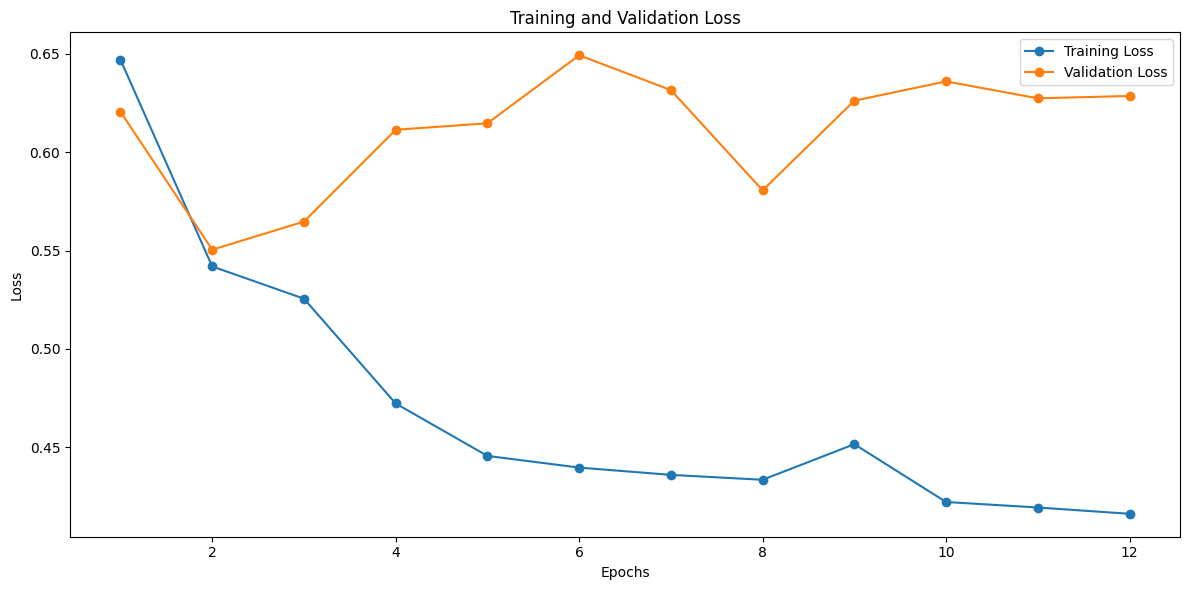

In [86]:
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_loss, label='Training Loss', marker='o')
plt.plot(epochs, val_loss, label='Validation Loss', marker='o')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.tight_layout()
plt.legend()
plt.show()


Evaluation Metric: Accuracy

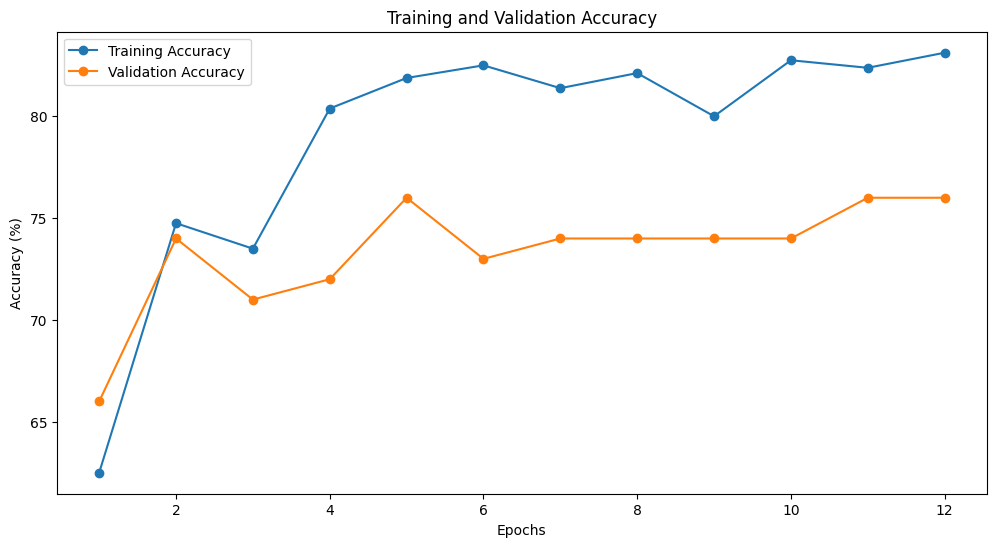

In [85]:
plt.figure(figsize=(12, 6))
plt.plot(epochs, train_accuracy, label='Training Accuracy', marker='o')
plt.plot(epochs, val_accuracy, label='Validation Accuracy', marker='o')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.tight_layout
plt.legend()
plt.show()


<font size =4> Findings </font>

The Model predicts yelp review sentiment with 77% accuracy

<font size=4> Implications </font>

1. Reputation Monitoring: 
    - Automatically flag negative reviews for damage control
    - Prioritize outreach to dissatisfied customers before issues escalate
2. Competitive Analysis:
    - Benchmark sentiment against competitors
    - Identify recurring complaints companies fail to address
3. Customer Feedback Insight:
    - Summarize public opinion across reviews to reveal key patterns
    - Use sentiment to guide service, product, and experience improvements